In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch import nn
import torch.nn.functional as F



#Sklearn
from sklearn.preprocessing import MinMaxScaler

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...


from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


# ML
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

manual_seed(444422)

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

def circuitoRegresor_CodificacionAngular(n_qubits=1):
    feature_map = ZZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(n_qubits, reps=3)
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

class Net(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc1 = nn.Linear(12, 2)
        self.fc3 = nn.Linear(2, 2)
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc2 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc3(x))
        x = self.qnn(x)  # apply QNN
        x = self.fc2(x)
        return x

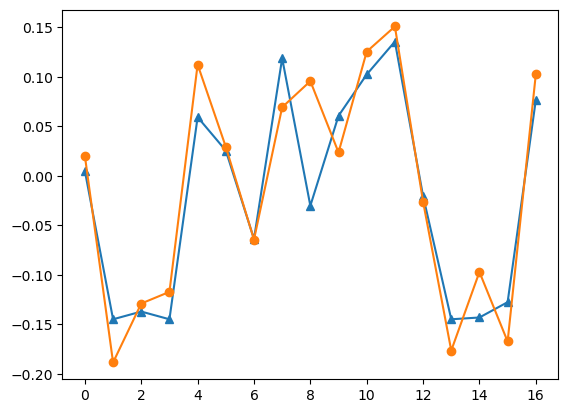

0.031566617717981325


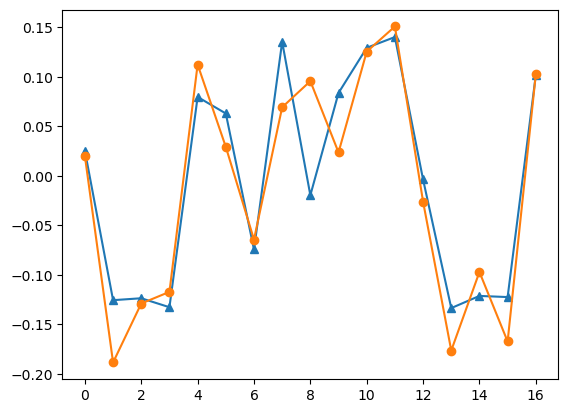

0.032838958357051765


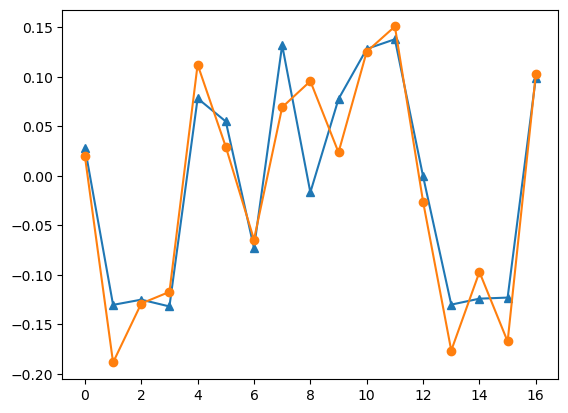

0.03068771087713714


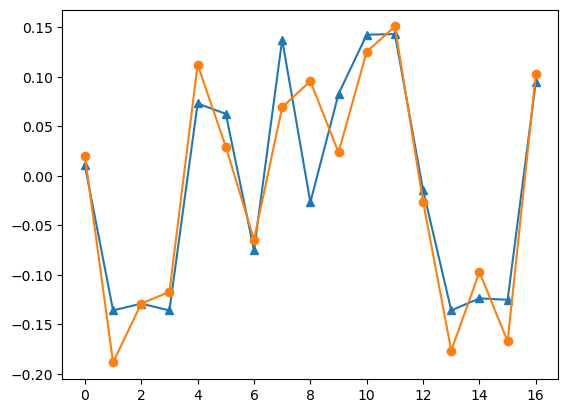

0.033734623330125654


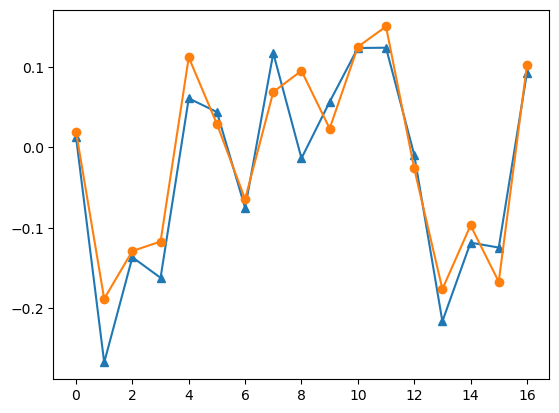

0.031685035063823565


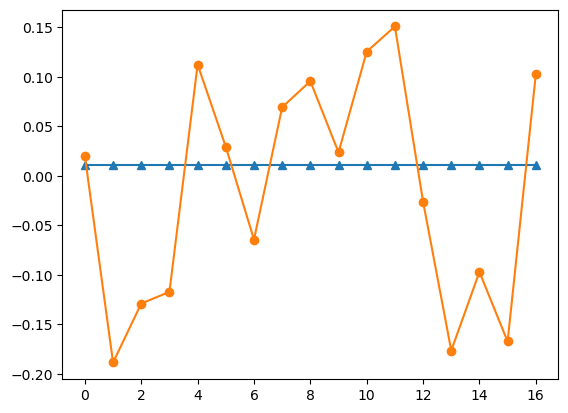

0.22379903973781187


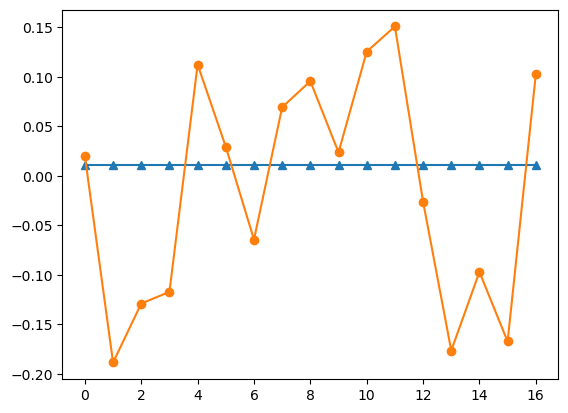

0.22325884000943133


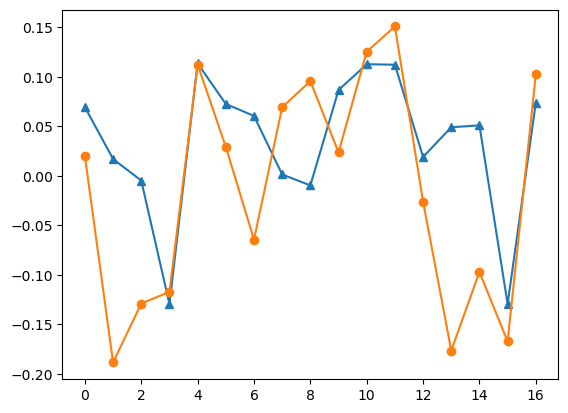

0.1758205007109286


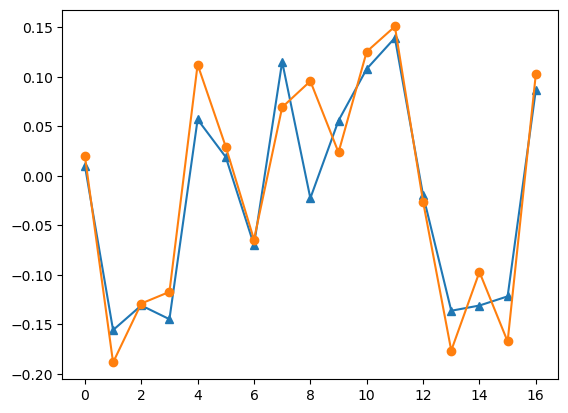

0.027790426402257477


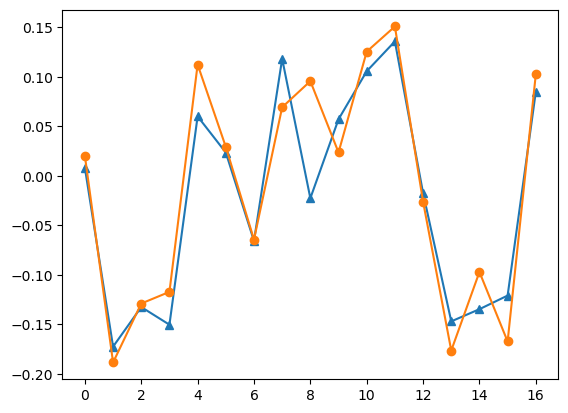

0.027184170402017673


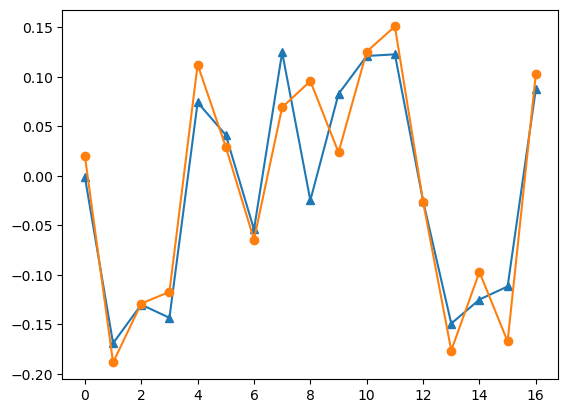

0.029880445648508863


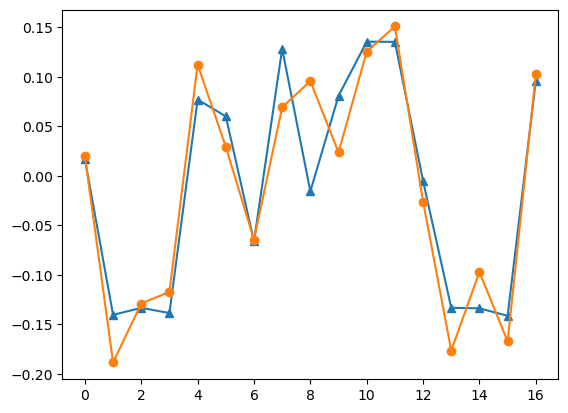

0.02880837850090209


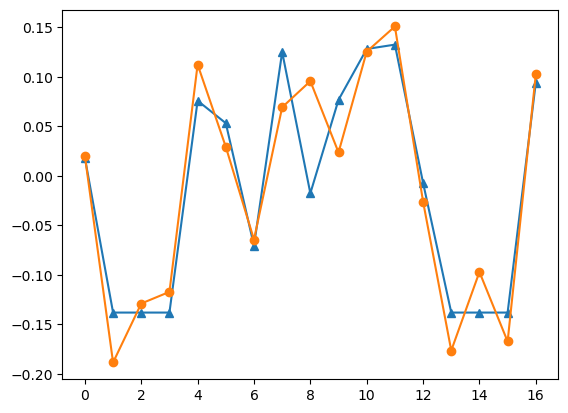

0.028504119229983943


KeyboardInterrupt: 

In [4]:
n_estadistico = 30
ptrain = 0.8
window = 12

train_losses = []
valid_losses = []
errores_cuadraticos_valid = []

for est in range(n_estadistico):
    
    # Partición de los datos
    pasajeros = np.array(data_shift['#Passengers'])
    pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
    pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]
    
    tam_train = pasajeros_train.shape[0] - window
    tam_test = pasajeros_test.shape[0] - window

    conjunto_train = []
    objetivo_train = []

    conjunto_test = []
    objetivo_test = []

    for i in range(0,tam_train):
        conjunto_train.append(pasajeros_train[0+i:window+i])
        objetivo_train.append(pasajeros_train[window+i])

    for i in range(0,tam_test):
        conjunto_test.append(pasajeros_test[0+i:window+i])
        objetivo_test.append(pasajeros_test[window+i])

    objetivo_train = np.array(objetivo_train)
    conjunto_train = np.array(conjunto_train)

    objetivo_test = np.array(objetivo_test)
    conjunto_test = np.array(conjunto_test)
    
    
    # Creación de los batches
    train = ElecDataset(conjunto_train.reshape(conjunto_train.shape[0],conjunto_train.shape[1],1),objetivo_train)
    test = ElecDataset(conjunto_test.reshape(conjunto_test.shape[0],conjunto_test.shape[1],1),objetivo_test)
    train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
    test_loader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False)

    # Creacion del modelo
    inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(2)
    modelo_cuantico = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params, input_gradients=True
    )
    redHibrida = Net(modelo_cuantico).double()
    optimizer = torch.optim.Adam(redHibrida.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Entrenamiento del modelo
    redHibrida.train()
    epochs = 100  # Set number of epochs
    loss_list = []  # Store loss history

    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = redHibrida(data)  # Forward pass
            #print("output ",output)
            #print("target ",target)
            loss = criterion(output, target)  # Calculate loss
            #print("loss ",loss)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            #print('--------------------------------------------------------------')
        loss_list.append(sum(total_loss) / len(total_loss))
        #print("Training {}/{}\tLoss: {:.20f}".format((epoch + 1), epochs ,loss_list[-1]))

    # Test
    redHibrida.eval()
    
    entrada = conjunto_test.reshape(conjunto_test.shape[0],conjunto_test.shape[1],1)

    prediction = []
    batch_size = 1
    iterations =  int(entrada.shape[0]/batch_size)

    for i in range(iterations):
        preds = redHibrida(torch.tensor(entrada[batch_size*i:batch_size*(i+1)]).double())
        prediction.append(preds[0].detach().numpy())
    prediction = np.array(prediction)

    plt.plot(prediction, marker='^')
    plt.plot(objetivo_test, marker='o')
    plt.show()
    
    error = 0

    for i in range(len(prediction)):
        error = error + (prediction[i] - objetivo_test[i])**2
    error/len(prediction)
    
    errores_cuadraticos_valid.append(error)
    print(error)

In [ ]:
errores_cuadraticos_valid = np.array(errores_cuadraticos_valid).reshape(len(errores_cuadraticos_valid))

print(errores_cuadraticos_valid)